In [1]:
%pylab inline
import torch

# Flag to enable execution on GPU
cuda = True if torch.cuda.is_available() else False

Populating the interactive namespace from numpy and matplotlib


# Dataset

In [2]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Loading the MNIST dataset
train_set = MNIST('./data/MNIST', download=True, train=True, transform=ToTensor())
test_set = MNIST('./data/MNIST', download=True, train=True, transform=ToTensor())

In [3]:
from torchvision.transforms import Compose, RandomAffine, ToTensor
from data_utils import PixelCorruption

# Defining the augmentations
t = Compose([
    RandomAffine(degrees=15,
                 translate=[0.1, 0.1],
                 scale=[0.9, 1.1],
                 shear=15), # Small affine transformations
    ToTensor(),             # Conversion to torch tensor
    PixelCorruption(0.8)    # PixelCorruption with keep probability 80%
])

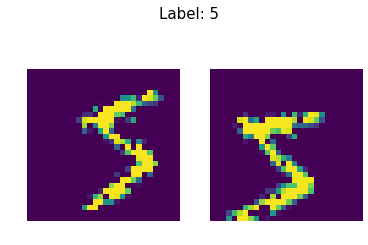

In [4]:
from data_utils import AugmentedDataset

# Creating the multi-view dataset
mv_train_set = AugmentedDataset(MNIST('./data/MNIST', train=True), t)

# Visualization of one example
f, ax = plt.subplots(1,2)

idx = 0
v_1, v_2, y = mv_train_set[idx]
f.suptitle('Label: %d'%y,size=15)
ax[0].imshow(v_1[0].data.numpy())
ax[1].imshow(v_2[0].data.numpy())
ax[0].axis('off')
ax[1].axis('off');

In [5]:
from torch.utils.data import DataLoader

batch_size = 64

# Initialization of the data loader
train_loader = DataLoader(mv_train_set, batch_size=batch_size, shuffle=True, num_workers=8 if cuda else 1)

# Defining the architectures

In [6]:
import torch.nn as nn
from torch.distributions import Normal, Independent
from torch.nn.functional import softplus

# Encoder architecture
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        
        self.z_dim = z_dim
        
        # Vanilla MLP
        self.net = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, z_dim*2),
        )
        
    def forward(self, x):
        x = x.view(x.size(0),-1) # Flatten the input
        params = self.net(x)
        
        mu, sigma = params[:,:self.z_dim], params[:,self.z_dim:]
        sigma = softplus(sigma) + 1e-7  # Make sigma always positive
        
        return Independent(Normal(loc=mu, scale=sigma), 1) # Return a factorized Normal distribution

# Auxiliary network for mutual information estimation
class MIEstimator(nn.Module):
    def __init__(self, size1, size2):
        super(MIEstimator, self).__init__()
        
        # Vanilla MLP
        self.net = nn.Sequential(
            nn.Linear(size1 + size2, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1),
        )
    
    # Gradient for JSD mutual information estimation and EB-based estimation
    def forward(self, x1, x2):
        pos = self.net(torch.cat([x1, x2], 1)) #Positive Samples 
        neg = self.net(torch.cat([torch.roll(x1, 1, 0), x2], 1)) #Predictions for shuffled (negative) samples from p(z1)p(z2)
        #breakpoint()
        return -softplus(-pos).mean() - softplus(neg).mean(), pos.mean() - neg.exp().mean() + 1
    


In [7]:
# Size of the representation
z_dim = 64

# Intialization of the encoder(s)
encoder_v_1 = Encoder(z_dim)
encoder_v_2 = encoder_v_1 # Full parameter sharing for the two encoders

# Initialization of the mutual information estimation network
mi_estimator = MIEstimator(z_dim, z_dim) 

# Moving the models to the GPU
if cuda:
    encoder_v_1 = encoder_v_1.cuda()
    encoder_v_2 = encoder_v_2.cuda()
    mi_estimator = mi_estimator.cuda()

In [8]:
from torch.optim import Adam

# Defining the optimizer
opt = Adam([
    {'params': encoder_v_1.parameters(), 'lr':1e-4},
#     {'params': encoder_v_2.parameters(), 'lr':1e-4}, # There is only one encoder in this example
    {'params': mi_estimator.parameters(), 'lr':1e-4},
])

# Evaluation

In [9]:
from evaluation import evaluate, split


# Select a subset (100 samples per label ~0.17 %) of labeled train points
train_subset = split(train_set, 10, 'Balanced') 

In [10]:
train_subset

# Training procedure

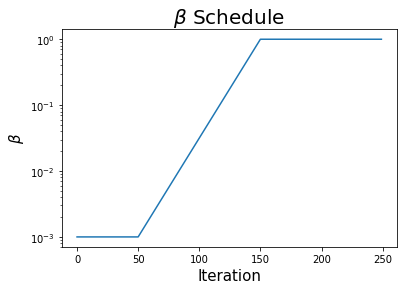

In [13]:
from data_utils import ExponentialScheduler

# Defining the schedule for the update of the hyper-parameter over time
beta_scheduler = ExponentialScheduler(start_value=1e-3, end_value=1, n_iterations=100, start_iteration=50)
# beta_scheduler = ExponentialScheduler(start_value=1e-3, end_value=1, n_iterations=100000, start_iteration=50000)

# Visualization of the scheduler behavior
iterations = np.arange(250)
plt.plot(iterations, [beta_scheduler(iteration) for iteration in iterations])
plt.title('$\\beta$ Schedule', size=20)
plt.yscale('log')
plt.xlabel('Iteration', size=15)
plt.ylabel('$\\beta$', size=15);

In [ ]:
from tqdm import tqdm_notebook as tqdm

# Training parameters
# Increase number of epochs and delay the beta increment for better performances
epochs = 300
iterations = 0
plot_every = 20
mi_over_time = []
skl_over_time = []

In [ ]:
# Training loop (approx 1h on GPU)
for epoch in tqdm(range(epochs)):
    for v_1, v_2, _ in train_loader:
        
        if cuda:
            v_1 = v_1.cuda()
            v_2 = v_2.cuda()
        
        # Encode a batch of data
        p_z_1_given_v_1 = encoder_v_1(v_1)
        p_z_2_given_v_2 = encoder_v_2(v_2)
        
        # Sample from the posteriors with reparametrization
        z_1 = p_z_1_given_v_1.rsample()
        z_2 = p_z_2_given_v_2.rsample()
        
        # Mutual information estimation
        mi_gradient, mi_estimation = mi_estimator(z_1,z_2)
        mi_gradient = mi_gradient.mean()
        mi_estimation = mi_estimation.mean()
        print(mi_estimation)
        # Symmetrized Kullback-Leibler divergence
        kl_1_2 = p_z_1_given_v_1.log_prob(z_1) - p_z_2_given_v_2.log_prob(z_1)
        kl_2_1 = p_z_2_given_v_2.log_prob(z_2) - p_z_1_given_v_1.log_prob(z_2)
        skl = (kl_1_2 + kl_2_1).mean()/ 2.

        # Update the value of beta according to the policy
        beta = beta_scheduler(iterations)
        iterations +=1
        
        # Computing the loss function
        loss = - mi_gradient + beta * skl
        
        # Logging
        mi_over_time.append(mi_estimation.item())
        skl_over_time.append(skl.item())
        
        # Backward pass and update
        opt.zero_grad()
        loss.backward()
        opt.step()   
    
    # Plot the loss components every 5 epochs
    if epoch % plot_every == 0:
        f, ax = plt.subplots(1,2, figsize=(8,3))
        ax[0].set_title('$I(z_1;z_2)$')
        ax[1].set_title('$D_{SKL}(p(z_1|v_1)||p(z_2|v_2))$')
        ax[1].set_yscale('log')
        ax[0].plot(mi_over_time, '.', alpha=0.1)
        ax[1].plot(skl_over_time, '.r', alpha=0.1)
        ax[0].set_ylim(0,8)
        ax[1].set_ylim(1e-3)
        
        f.suptitle('Epoch: %d'%epoch, fontsize=15)
        plt.show()
        
        # Compute train and test_accuracy of a logistic regression
        train_accuracy, test_accuracy = evaluate(encoder=encoder_v_1, train_on=train_subset, test_on=test_set, cuda=cuda)
        print('Train Accuracy: %f'% train_accuracy)
        print('Test Accuracy: %f'% test_accuracy)
        
    

> <ipython-input-7-17e78d11dfb8>(49)forward()
-> return -softplus(-pos).mean() - softplus(neg).mean(), pos.mean() - neg.exp().mean() + 1
(Pdb) pos
tensor([[-5.1863e-02],
        [ 3.0027e-02],
        [ 2.3685e-02],
        [ 3.1210e-02],
        [-1.1133e-02],
        [-5.2478e-02],
        [-1.3885e-01],
        [-4.1310e-02],
        [-5.9979e-02],
        [-6.0139e-02],
        [-6.9977e-02],
        [-6.2791e-02],
        [-3.2100e-02],
        [-2.3803e-02],
        [-6.7242e-02],
        [-3.5637e-02],
        [-9.3962e-02],
        [-1.1038e-01],
        [-7.0551e-02],
        [-4.6513e-02],
        [-3.0850e-02],
        [-2.4909e-05],
        [-2.2548e-02],
        [-1.9792e-02],
        [-6.8624e-03],
        [ 2.2254e-02],
        [-1.0465e-01],
        [-7.9801e-02],
        [-3.5179e-02],
        [-4.7278e-02],
        [-1.3955e-01],
        [-4.5219e-02],
        [-5.9680e-02],
        [-3.5988e-02],
        [-1.8454e-02],
        [-2.3996e-02],
        [-1.6494e-02],
  

In [27]:
# Testing with 1 sample per label (~0.0017 % of labeled train points)
train_smallest_subset = split(train_set, 10, 'Balanced') 
print(train_smallest_subset)
train_accuracy, test_accuracy = evaluate(encoder=encoder_v_1, train_on=train_smallest_subset, test_on=test_set, cuda=cuda)
print('Train Accuracy: %f'% train_accuracy)
print('Test Accuracy: %f'% test_accuracy)

Train Accuracy: 1.000000
Test Accuracy: 0.235450
